# Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import shap

In [2]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.3 MB/s eta 0:00:00


# Reading Data

In [3]:
file_path = '/content/Sleep_health_and_lifestyle_dataset.csv'

if not os.path.exists(file_path):
    raise FileNotFoundError('파일을 찾을 수 없습니다.')

df = pd.read_csv(file_path)
print(df.shape)
print(df.columns.tolist())
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

(374, 13)
['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4          

# EDA

['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']


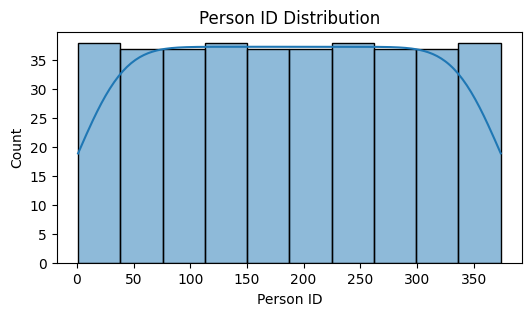

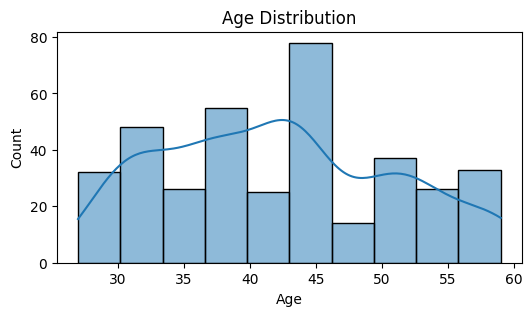

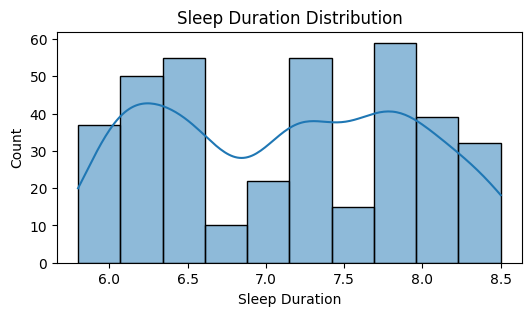

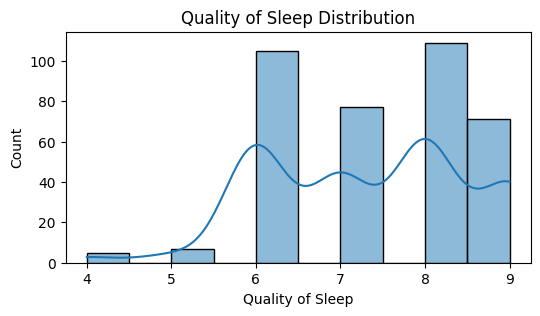

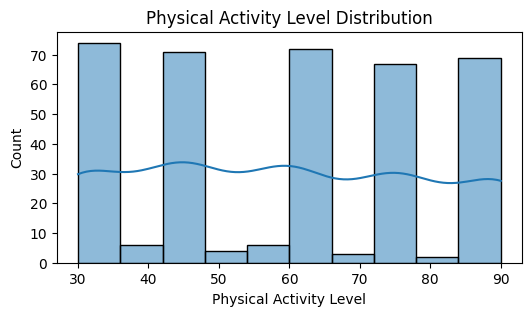

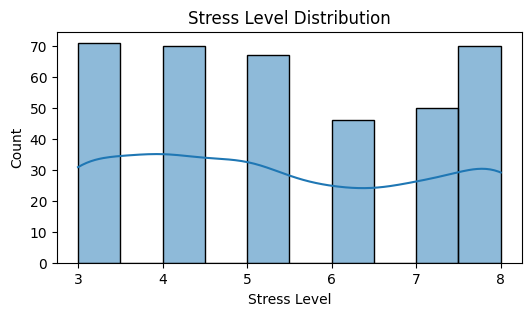

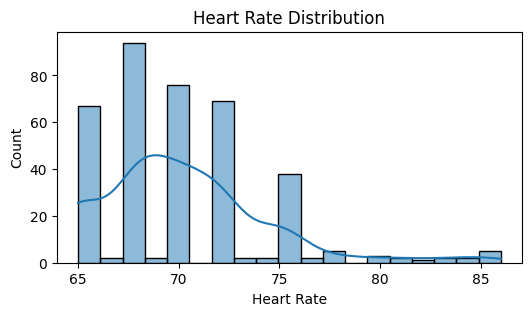

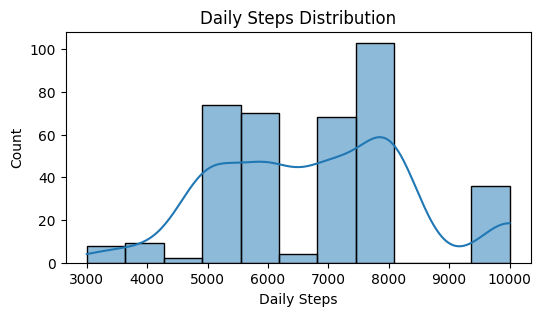

['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']


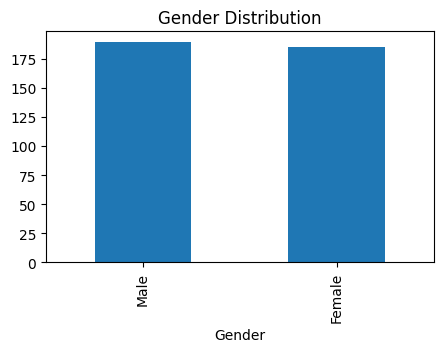

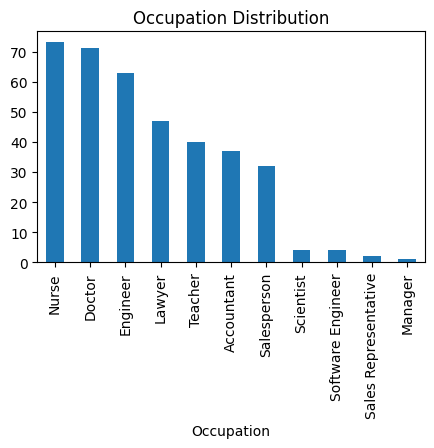

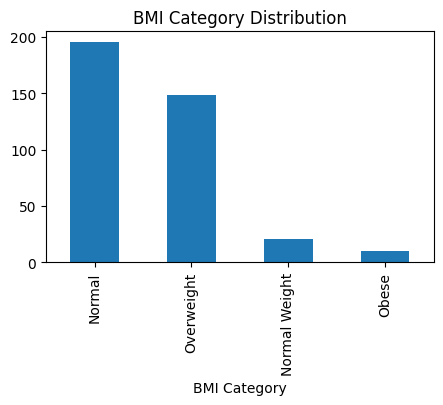

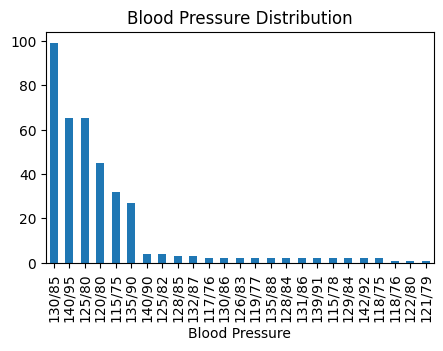

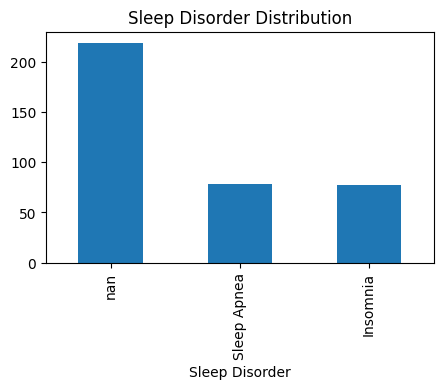

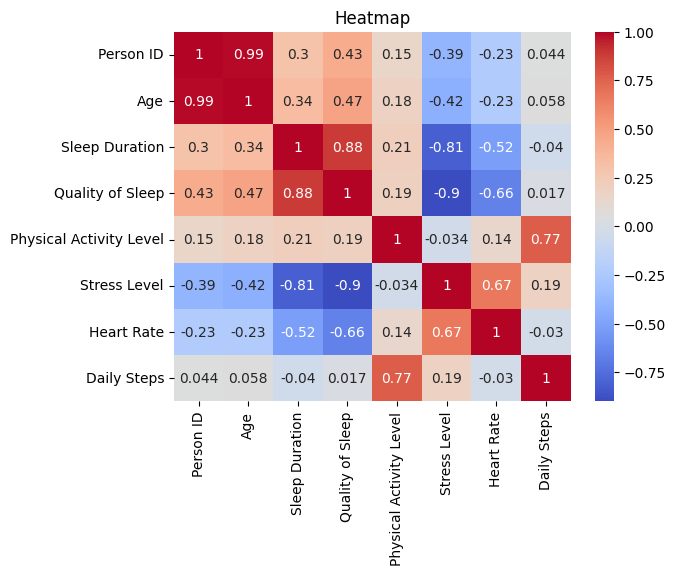

In [4]:
print(df.select_dtypes(include=np.number).columns.tolist())

for col in df.select_dtypes(include=np.number).columns.tolist():
    plt.figure(figsize=(6,3))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'{col} Distribution')
    plt.show()

print(df.select_dtypes(exclude=np.number).columns.tolist())

for col in df.select_dtypes(exclude=np.number).columns.tolist():
    plt.figure(figsize=(5,3))
    df[col].value_counts(dropna=False).plot(kind='bar')
    plt.title(f'{col} Distribution')
    plt.show()

sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap")
plt.show()

# Data preprocessing

In [5]:
target_col = 'Sleep Disorder'

if target_col not in df.columns:
    raise KeyError('Sleep Disorder가 없습니다.')

y_raw = df[target_col].fillna('Normal').astype(str)
le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)

print('타겟 클래스:', le_target.classes_)
print('레이블 매핑:', dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))

타겟 클래스: ['Insomnia' 'Normal' 'Sleep Apnea']
레이블 매핑: {'Insomnia': np.int64(0), 'Normal': np.int64(1), 'Sleep Apnea': np.int64(2)}


In [6]:
X = df.copy()

if 'Person ID' not in X.columns:
   raise KeyError('Person ID가 없습니다.')

# 'Sleep Disorcer'와 'Person ID'는 모델 학습에 사용하지 않으므로 제거
X.drop(columns=['Sleep Disorder', 'Person ID'], inplace=True)

bp = [c for c in X.columns if 'Blood Pressure' in c]

# Blood Pressure을 Systolic/Diastolic로 분리
if bp:
  bp_col = bp[0]
  bp = X[bp_col].astype(str).str.extract(r'(?P<Systolic>\d{2,3})\D+(?P<Diastolic>\d{2,3})')
  X['Systolic'] = pd.to_numeric(bp['Systolic'], errors='coerce')
  X['Diastolic'] = pd.to_numeric(bp['Diastolic'], errors='coerce')
  X.drop(columns=[bp_col], inplace=True)
else:
  X['Systolic'] = np.nan
  X['Diastolic'] = np.nan

# 혈압 상태 카테고리 분류 함수
def bp_category(sys, dia):
    if pd.isna(sys) or pd.isna(dia): return 'Unknown'
    if sys >= 140 or dia >= 90: return 'High'
    if (130 <= sys <= 139) or (80 <= dia <= 89): return 'Borderline'
    return 'Normal'

# 혈압 상태 카테고리 분류 적용
X['BP Category'] = X.apply(lambda r: bp_category(r['Systolic'], r['Diastolic']), axis=1)
X.drop(columns=['Systolic', 'Diastolic'], inplace=True)

In [7]:
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# 레이블 인코딩을 적용
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le # 역변환을 위해 인코더 저장

In [8]:
# 학습/테스트 데이터 분할, 클래스 비율 유지
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 테스트 데이터에서 검증 데이터 추가 분할(과적합 방지용)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f'학습 데이터: {X_tr.shape}, 검증 데이터: {X_val.shape}, 테스트 데이터: {X_test.shape}')

categorical_features = [X.columns.get_loc(c) for c in cat_cols]

# SMOTENC 설정
smote_nc = SMOTENC(
    categorical_features=categorical_features,
    random_state=42
)

# 학습 데이터를 대상으로 클래스 불균형 처리
# 연속형 + 범주형 데이터 혼합 환경에서 오버샘플링을 수행
X_tr_res, y_tr_res = smote_nc.fit_resample(X_tr, y_tr)

print(f'학습 데이터(SMOTE 적용 후): {X_tr_res.shape}')

학습 데이터: (208, 11), 검증 데이터: (53, 11), 테스트 데이터: (113, 11)
학습 데이터(SMOTE 적용 후): (366, 11)


# Data modeling

In [9]:
results = {} # 모델별 하이퍼파라미터 실험 결과 저장

xgb_baseline = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=3
)

xgb_baseline.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
pred_xgb_baseline = xgb_baseline.predict(X_test)

results['XGB_Baseline'] = {
    'model': xgb_baseline,
    'pred': pred_xgb_baseline,
    'pred_proba': xgb_baseline.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_baseline),
    'f1_macro': f1_score(y_test, pred_xgb_baseline, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_baseline, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_baseline, average='macro')
}

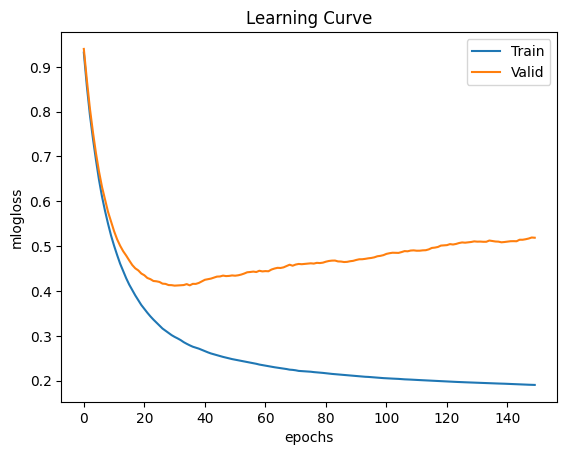

In [10]:
xgb_baseline_result = xgb_baseline.evals_result_
epochs = len(xgb_baseline_result['validation_0']['mlogloss'])

plt.title('Learning Curve')
plt.plot(range(epochs), xgb_baseline_result['validation_0']['mlogloss'], label='Train')
plt.plot(range(epochs), xgb_baseline_result['validation_1']['mlogloss'], label='Valid')
plt.xlabel('epochs')
plt.ylabel('mlogloss')
plt.legend()
plt.show()

In [11]:
xgb_tuned = XGBClassifier(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.65,
    random_state=42,
    eval_metric='mlogloss',
    early_stopping_rounds=50,
    objective='multi:softprob',
    num_class=3
)

xgb_tuned.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
pred_xgb_tuned = xgb_tuned.predict(X_test)

results['XGB_Tuned'] = {
    'model': xgb_tuned,
    'pred': pred_xgb_tuned,
    'pred_proba': xgb_tuned.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_tuned),
    'f1_macro': f1_score(y_test, pred_xgb_tuned, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_tuned, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_tuned, average='macro')
}

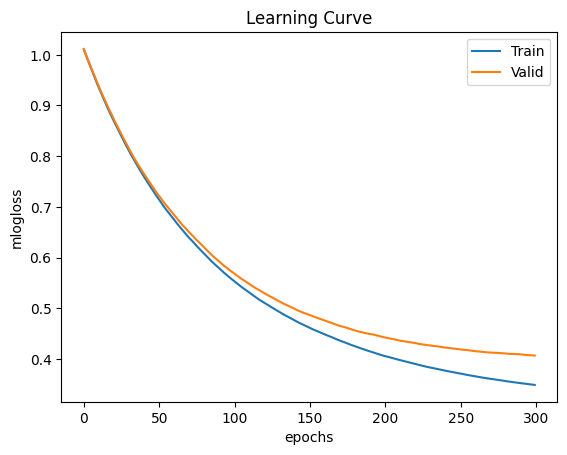

In [12]:
xgb_tuned_result = xgb_tuned.evals_result_
epochs = len(xgb_tuned_result['validation_0']['mlogloss'])

plt.title('Learning Curve')
plt.plot(range(epochs), xgb_tuned_result['validation_0']['mlogloss'], label='Train')
plt.plot(range(epochs), xgb_tuned_result['validation_1']['mlogloss'], label='Valid')
plt.xlabel('epochs')
plt.ylabel('mlogloss')
plt.legend()
plt.show()

In [13]:
# RandomizedSearchCV를 위한 하이퍼파라미터 탐색 범위 설정
param_dist = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [2, 3, 4, 5],
    'min_child_weight': [2, 3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

xgb_random_search = RandomizedSearchCV(
    XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=3
    ),
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=5,
    random_state=42,
)

xgb_random_search.fit(X_train, y_train)

# 최적화 실패했을 때를 위한 예외 처리
if not hasattr(xgb_random_search, 'best_estimator_'):
    print("Warning: Optimization failed or best estimator is not available. Skipping result logging.")
else:
    pred_xgb_random_search = xgb_random_search.predict(X_test)


results['XGB_RandomSearch'] = {
    'model': xgb_random_search,
    'pred': pred_xgb_random_search,
    'pred_proba': xgb_random_search.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_random_search),
    'f1_macro': f1_score(y_test, pred_xgb_random_search, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_random_search, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_random_search, average='macro')
}

print(f'최적 파라미터: {xgb_random_search.best_params_}')

최적 파라미터: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [14]:
# GridSearchCV를 위한 하이퍼파라미터 탐색 범위 설정
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.05],
    'max_depth': [2, 3, 4],
    'min_child_weight': [3, 5],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
}

xgb_grid_search = GridSearchCV(
    XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=3
    ),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
)

xgb_grid_search.fit(X_train, y_train)

# GridSearchCV 최적화 실패 시 예외 처리 추가
if not hasattr(xgb_grid_search, 'best_estimator_'):
    print("Warning: GridSearchCV failed or best estimator is not available. ")
else:
    # 최적의 예측기(best_estimator_)가 있을 경우에만 예측 및 결과 기록을 진행하도록 함
    pred_xgb_grid_search = xgb_grid_search.predict(X_test)

results['XGB_GridSearch'] = {
    'model': xgb_grid_search,
    'pred': pred_xgb_grid_search,
    'pred_proba': xgb_grid_search.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_grid_search),
    'f1_macro': f1_score(y_test, pred_xgb_grid_search, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_grid_search, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_grid_search, average='macro')
}


print(f'최적 파라미터: {xgb_grid_search.best_params_}')


최적 파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.7}


In [15]:
# Hyperopt를 위한 하이퍼파라미터 탐색 범위 설정
# 베이지안 최적화 기반 탐색
hyperopt_space = {
    'n_estimators': hp.quniform('n_estimators', 250, 500, 50),
    'learning_rate': hp.uniform('learning_rate', 0.03, 0.15),
    'max_depth': hp.quniform('max_depth', 2, 4, 1),
    'min_child_weight': hp.quniform('min_child_weight', 4, 8, 1),
    'subsample': hp.uniform('subsample', 0.6, 0.8),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.75),
}

# Hyperopt를 위한 하이퍼파라미터 탐색 목적 함수 정의
def objective_hyperopt(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    model = XGBClassifier(
        **params,
        random_state=42,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=3
    )
    # 교차 검증을 통해 f1_macro 점수를 계산
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best_params_hyperopt = fmin(
    fn=objective_hyperopt,
    space=hyperopt_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42),
)

best_params_hyperopt['n_estimators'] = int(best_params_hyperopt['n_estimators'])
best_params_hyperopt['max_depth'] = int(best_params_hyperopt['max_depth'])
best_params_hyperopt['min_child_weight'] = int(best_params_hyperopt['min_child_weight'])

xgb_hyperopt = XGBClassifier(
    **best_params_hyperopt,
    random_state=42,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=3,
    early_stopping_rounds=30,
)

xgb_hyperopt.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
pred_xgb_hyperopt = xgb_hyperopt.predict(X_test)

results['XGB_Hyperopt'] = {
    'model': xgb_hyperopt,
    'pred': pred_xgb_hyperopt,
    'pred_proba': xgb_hyperopt.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_hyperopt),
    'f1_macro': f1_score(y_test, pred_xgb_hyperopt, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_hyperopt, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_hyperopt, average='macro')
}

best_params = space_eval(hyperopt_space, best_params_hyperopt)
print(f'최적 파라미터 {best_params}')


100%|██████████| 50/50 [00:58<00:00,  1.17s/trial, best loss: -0.883039718885947]
최적 파라미터 {'colsample_bytree': 0.660535431198673, 'learning_rate': 0.07057986977944468, 'max_depth': 3.0, 'min_child_weight': 5.0, 'n_estimators': 250.0, 'subsample': 0.7005807509322963}


In [16]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optuna를 위한 하이퍼파라미터 탐색 목적 함수 정의
# 베이지안 최적화 기반 탐색
def objective_optuna(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 250, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.15),
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'min_child_weight': trial.suggest_int('min_child_weight', 4, 8),
        'subsample': trial.suggest_float('subsample', 0.6, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.75),
        'random_state': 42,
        'eval_metric': 'mlogloss',
        'objective':'multi:softprob',
        'num_class': 3
    }

    xgb_optuna = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(xgb_optuna, X_train, y_train, cv=cv, scoring='f1_macro').mean()

    return scores

study = optuna.create_study(direction='maximize')
study.optimize(objective_optuna, n_trials=50)

xgb_optuna = XGBClassifier(
    **study.best_params,
    random_state=42,
    eval_metric='mlogloss',
    early_stopping_rounds=30,
    objective='multi:softprob',
    num_class=3,
)

xgb_optuna.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
pred_xgb_optuna = xgb_optuna.predict(X_test)

results['XGB_Optuna'] = {
    'model': xgb_optuna,
    'pred': pred_xgb_optuna,
    'pred_proba': xgb_optuna.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_optuna),
    'f1_macro': f1_score(y_test, pred_xgb_optuna, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_optuna, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_optuna, average='macro')
}

print(f'최적 파라미터: {study.best_params}')

최적 파라미터: {'n_estimators': 350, 'learning_rate': 0.07601258928077795, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7574613466783358, 'colsample_bytree': 0.629225668887541}


In [17]:
xgb_baseline_smote = Pipeline([
    ('smote', smote_nc),
    ('model', XGBClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=3
    ))
])

xgb_baseline_smote.fit(X_tr, y_tr)
pred_xgb_baseline = xgb_baseline_smote.predict(X_test)


results['XGB_Baseline_SMOTE'] = {
    'model': xgb_baseline_smote,
    'pred': pred_xgb_baseline,
    'pred_proba': xgb_baseline_smote.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_baseline),
    'f1_macro': f1_score(y_test, pred_xgb_baseline, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_baseline, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_baseline, average='macro')
}

In [18]:
# Optuna/GridSearch를 통해 찾은 optimal parameter 사용하여 최종 모델을 구성하고 학습
xgb_tuned_smote = Pipeline([
    ('smote', smote_nc),
    ('model', XGBClassifier(
        n_estimators=500,
        learning_rate=0.08,
        max_depth=3,
        min_child_weight=7,
        subsample=0.7,
        colsample_bytree=0.65,
        random_state=42,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=3
    ))
])

xgb_tuned_smote.fit(X_tr, y_tr)
pred_xgb_tuned_smote = xgb_tuned_smote.predict(X_test)

results['XGB_Tuned_SMOTE'] = {
    'model': xgb_tuned_smote,
    'pred': pred_xgb_tuned_smote,
    'pred_proba': xgb_tuned_smote.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_tuned_smote),
    'f1_macro': f1_score(y_test, pred_xgb_tuned_smote, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_tuned_smote, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_tuned_smote, average='macro')
}

In [19]:
param_dist = {
    'model__n_estimators': [300, 500, 700],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__max_depth': [2, 3, 4, 5],
    'model__min_child_weight': [2, 3, 5, 7],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9],
}

xgb_random_search_smote = RandomizedSearchCV(
    Pipeline([
        ('smote', smote_nc),
        ('model', XGBClassifier(
            eval_metric='mlogloss',
            objective='multi:softprob',
            num_class=3,
            random_state=42
        ))
    ]),
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_macro',
    cv=5,
    random_state=42
)

xgb_random_search_smote.fit(X_train, y_train)
pred_xgb_random_smote = xgb_random_search_smote.predict(X_test)

results['XGB_RandomSearch_SMOTE'] = {
    'model': xgb_random_search_smote,
    'pred': pred_xgb_random_smote,
    'pred_proba': xgb_random_search_smote.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_random_smote),
    'f1_macro': f1_score(y_test, pred_xgb_random_smote, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_random_smote, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_random_smote, average='macro')
}

print(f'최적 파라미터: {xgb_random_search_smote.best_params_}')

최적 파라미터: {'model__subsample': 0.9, 'model__n_estimators': 700, 'model__min_child_weight': 7, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.9}


In [20]:
param_grid = {
    'model__n_estimators': [300, 500],
    'model__learning_rate': [0.01, 0.05],
    'model__max_depth': [2, 3, 4],
    'model__min_child_weight': [3, 5],
    'model__subsample': [0.7, 0.8],
    'model__colsample_bytree': [0.7, 0.8]
}


xgb_grid_smote = GridSearchCV(
    Pipeline([
        ('smote', smote_nc),
        ('model', XGBClassifier(
            eval_metric='mlogloss',
            objective='multi:softprob',
            num_class=3,
            random_state=42
        ))
    ]),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5
)

xgb_grid_smote.fit(X_train, y_train)
pred_xgb_grid_smote = xgb_grid_smote.predict(X_test)

results['XGB_GridSearch_SMOTE'] = {
    'model': xgb_grid_smote,
    'pred': pred_xgb_grid_smote,
    'pred_proba': xgb_grid_smote.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_grid_smote),
    'f1_macro': f1_score(y_test, pred_xgb_grid_smote, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_grid_smote, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_grid_smote, average='macro')
}


print(f'최적 파라미터: {xgb_grid_smote.best_params_}')


최적 파라미터: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__min_child_weight': 5, 'model__n_estimators': 500, 'model__subsample': 0.7}


In [ ]:
def objective_hyperopt_smote(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    model = Pipeline([
        ('smote', smote_nc),
        ('model', XGBClassifier(
            **params,
            random_state=42,
            eval_metric='mlogloss',
            objective='multi:softprob',
            num_class=3
        ))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best_params_hyperopt = fmin(
    fn=objective_hyperopt_smote,
    space=hyperopt_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42),
)

best_params_hyperopt['n_estimators'] = int(best_params_hyperopt['n_estimators'])
best_params_hyperopt['max_depth'] = int(best_params_hyperopt['max_depth'])
best_params_hyperopt['min_child_weight'] = int(best_params_hyperopt['min_child_weight'])

xgb_hyperopt_smote = Pipeline([
    ('smote', smote_nc),
    ('model', XGBClassifier(
        **best_params_hyperopt,
        random_state=42,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=3,
    ))
])

xgb_hyperopt_smote.fit(X_train, y_train)
pred_xgb_hyperopt_smote = xgb_hyperopt_smote.predict(X_test)

results['XGB_Hyperopt_SMOTE'] = {
    'model': xgb_hyperopt_smote,
    'pred': pred_xgb_hyperopt_smote,
    'pred_proba': xgb_hyperopt_smote.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_hyperopt_smote),
    'f1_macro': f1_score(y_test, pred_xgb_hyperopt_smote, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_hyperopt_smote, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_hyperopt_smote, average='macro')
}

best_params = space_eval(hyperopt_space, best_params_hyperopt)
print(f'최적 파라미터 {best_params}')


 52%|█████▏    | 26/50 [00:31<00:23,  1.01trial/s, best loss: -0.8716313868266974]

In [ ]:
def objective_optuna_smote(trial):
    model = Pipeline([
        ('smote', smote_nc),
        ('model', XGBClassifier(
            n_estimators=trial.suggest_int('n_estimators', 250, 500, step=50),
            learning_rate=trial.suggest_float('learning_rate', 0.03, 0.15),
            max_depth=trial.suggest_int('max_depth', 2, 4),
            min_child_weight=trial.suggest_int('min_child_weight', 4, 8),
            subsample=trial.suggest_float('subsample', 0.6, 0.8),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 0.75),
            random_state=42,
            eval_metric='mlogloss',
            objective='multi:softprob',
            num_class=3
        ))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective_optuna_smote, n_trials=50)

xgb_optuna_smote = Pipeline([
    ('smote', smote_nc),
    ('model', XGBClassifier(
        **study.best_params,
        random_state=42,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=3
    ))
])

# optuna 최적화를 통해 얻은 optimal parameter 사용하여 최종 모델 구성
xgb_optuna_smote.fit(X_train, y_train)
pred_xgb_optuna_smote = xgb_optuna_smote.predict(X_test)

results['XGB_Optuna_SMOTE'] = {
    'model': xgb_optuna_smote,
    'pred': pred_xgb_optuna_smote,
    'pred_proba': xgb_optuna_smote.predict_proba(X_test),
    'accuracy': accuracy_score(y_test, pred_xgb_optuna_smote),
    'f1_macro': f1_score(y_test, pred_xgb_optuna_smote, average='macro'),
    'precision_macro': precision_score(y_test, pred_xgb_optuna_smote, average='macro'),
    'recall_macro': recall_score(y_test, pred_xgb_optuna_smote, average='macro')
}

print(f'최적 파라미터: {study.best_params}')

# Models evaluation

In [ ]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [v['accuracy'] for v in results.values()],
    'F1_Macro': [v['f1_macro'] for v in results.values()],
    'Recall_Macro': [v['recall_macro'] for v in results.values()],
    'Precision_Macro': [v['precision_macro'] for v in results.values()],
})

# 불균형 데이터셋에 대응하고 목표에 맞는 모델 선택을 위한 가중치 정의
w_f1 = 0.5 # 불균형 데이터 대응을 위해 가중치를 높게 설정
w_recall = 0.4
w_precision = 0.1


results_df['Weight_Score'] = (
    results_df['F1_Macro'] * w_f1 +
    results_df['Recall_Macro'] * w_recall +
    results_df['Precision_Macro'] * w_precision
)

results_df = results_df.sort_values('Weight_Score', ascending=False)
print(results_df)

for metric in ['Weight_Score', 'F1_Macro', 'Recall_Macro', 'Precision_Macro', 'Accuracy']:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=metric, y='Model', data=results_df, palette='Blues')
    plt.title(f'Model Comparison: {metric}')
    plt.tight_layout()
    plt.show()

In [ ]:
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_pred = results[best_model_name]['pred']

print(f'Best Model: {best_model_name}')

# RandomizedSearchCV이거나 GridSearchCV이면 best_estimator_ 사용
if hasattr(best_model, 'best_estimator_'):
    final_model = best_model.best_estimator_
else:
    final_model = best_model

# Pipeline이면 마지막 단계 모델 사용
if hasattr(final_model, 'steps'):
    final_model = final_model.named_steps[final_model.steps[-1][0]]

print('\nClassification report:')
print(classification_report(y_test, best_pred, target_names=le_target.classes_))

cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_target.classes_, yticklabels=le_target.classes_, cmap='Blues')
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Confusion Matrix')
plt.show()

if hasattr(final_model, 'feature_importances_'):
    importances = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print('Feature Importances:\n', importances)

    plt.figure(figsize=(8,5))
    importances.plot(kind='bar')
    plt.title('Feature Importances ')
    plt.tight_layout()
    plt.show()
else:
    print('Feature Importances are not available for this model.')

# SHAP

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

print(f'Target Classes: {le_target.classes_}')


print('Insomnia에 영향을 미치는 요인')
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[:, :, 0], X_test, plot_type='bar')
plt.show()
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[:, :, 0], X_test, plot_type='dot')
plt.tight_layout()
plt.show()


print('Sleep Apnea에 영향을 미치는 요인')
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[:, :, 2], X_test, plot_type='bar')
plt.show()
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[:, :, 2], X_test, plot_type='dot')
plt.tight_layout()
plt.show()


In [ ]:
X_test_display = X_test.copy()

# SHAP 시각화를 위해 레이블 인코딩 이전 상태로 복원
for col in cat_cols:
    if col in le_dict:
        X_test_display[col] = le_dict[col].inverse_transform(X_test[col].astype(int))

# 1st plot : 'Physical Activity Level'에 대한 SHAP 값

plt.figure(figsize=(10, 6))
print('Physical Acitvity Level과 Sleep Duration간 SHAP 의존도')
shap.dependence_plot(
    ind='Physical Activity Level',
    shap_values=shap_values[:, :, 0],
    features=X_test,
    display_features=X_test_display,
    interaction_index='Sleep Duration'
)
plt.show()

# 2nd plot : 'Sleep Duration'에 대한 SHAP 값

print('Sleep Duration과 Quality of Sleep간 SHAP 의존도')
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    ind='Sleep Duration',
    shap_values=shap_values[:, :, 2],
    features=X_test,
    display_features=X_test_display,
    interaction_index='Quality of Sleep'
)
plt.show()

In [ ]:
analysis_df = pd.DataFrame({
    'Occupation': X_test_display['Occupation'],
    'SHAP Value (Sleep Apnea)': shap_values[:, :, 2][:, X_test.columns.get_loc('Occupation')]
})

# fig, ax 정의
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(
    data=analysis_df,
    x='Occupation',
    y='SHAP Value (Sleep Apnea)',
    hue='Occupation',
    legend=False,
    showfliers=False,
    ax=ax
)

sns.stripplot(
    data=analysis_df,
    x='Occupation',
    y='SHAP Value (Sleep Apnea)',
    color='blue',
    alpha=0.3,
    ax=ax
)

plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.title('Impact of Occupation on Sleep Apnea')
plt.xticks(rotation=90)
plt.show()